<a href="https://colab.research.google.com/github/ShawnLiu119/CapstoneProject_BankingMarketing/blob/main/BankMkting_Clustering_CustomerSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd 
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,r2_score
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
import warnings
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering, KMeans, Birch

In [2]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
url = 'https://raw.githubusercontent.com/ShawnLiu119/CapstoneProject_BankingMarketing/main/rawdata/bank-additional-full.csv'
data = pd.read_csv(url, sep=';')

### General Function Setup

In [4]:
data_2 = data.copy()
data_2.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [5]:
##Since we are segmenting customers, the non customer-relevant features are going to be dropped such as macro economic indicator
df_clus = data_2[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'duration', 'pdays', 'poutcome', 'y']]

In [6]:
df_clus['y'] = df_clus['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))

In [7]:
cols = df_clus.columns

num_cols = df_clus._get_numeric_data().columns

cat_col = list(set(cols) - set(num_cols))

cat_col 

['education', 'default', 'housing', 'loan', 'poutcome', 'marital', 'job']

In [8]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()

for col in cat_col:
  df_clus[col] = label.fit_transform(df_clus[col])

df_clus.head()

,age,job,marital,education,default,housing,loan,duration,pdays,poutcome,y
0,56,3,1,0,0,0,0,261,999,1,0
1,57,7,1,3,1,0,0,149,999,1,0
2,37,7,1,3,0,2,0,226,999,1,0
3,40,0,1,1,0,0,0,151,999,1,0
4,56,7,1,3,0,0,2,307,999,1,0


###Data Normalization - Standardscale

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(df_clus)

###PCA Applied before doing clustering to reduce dimensionality

In [10]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x)

pca.explained_variance_ratio_

array([0.16109964, 0.14008793, 0.10941848, 0.1003905 , 0.09494452,
       0.08682102, 0.08669922, 0.07145662, 0.05887838, 0.05061876,
       0.03958493])

Text(0, 0.5, 'Cumulative explained variance')

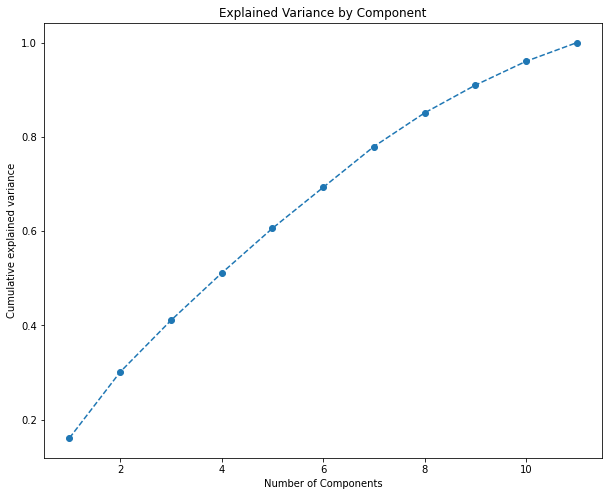

In [11]:
plt.figure(figsize = (10, 8))
plt.plot(range(1,12), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Explained Variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative explained variance')

In [12]:
#there is no obvious infection point on the curve, so we will use 80% as threshold to determine the number of principal component

pca = PCA(n_components = 7)

x_pca = pca.fit_transform(x)

In [13]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = df_clus.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_pca_fea = pd.DataFrame(dic.items())

In [14]:
df_pca_fea = df_pca_fea.rename(columns={0: 'PCA', 1: 'Feature'})
df_pca_fea

,PCA,Feature
0,PC0,pdays
1,PC1,age
2,PC2,duration
3,PC3,job
4,PC4,loan
5,PC5,housing
6,PC6,job


### KMeans Clustering

In [15]:
wcss = []

for i in range(1, 21):
  kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  kmeans_pca.fit(x_pca)
  wcss.append(kmeans_pca.inertia_)

Text(0, 0.5, 'WCSS-Within-Cluster Sum of Square')

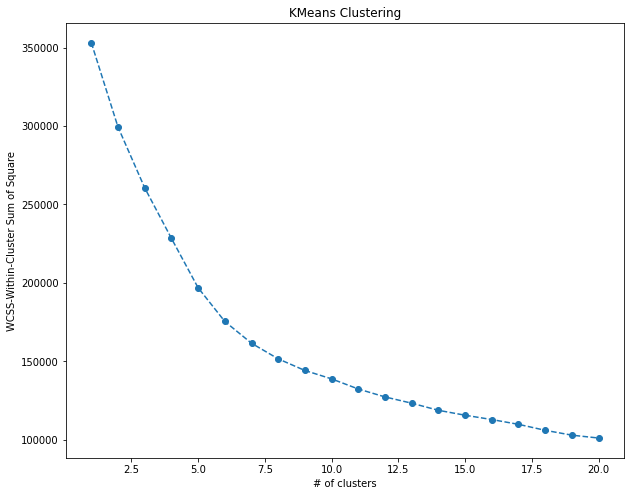

In [16]:
plt.figure(figsize = (10, 8))
plt.plot(range(1,21), wcss, marker='o', linestyle = '--')
plt.title('KMeans Clustering')
plt.xlabel('# of clusters')
plt.ylabel('WCSS-Within-Cluster Sum of Square')

And from this graph, we determine the number of clusters we’d like to keep. To that effect, we use the Elbow-method. The approach consists of looking for a kink or elbow in the WCSS graph. Usually, the part of the graph before the elbow would be steeply declining, while the part after it – much smoother. In this instance, the kink comes at the 4 clusters mark. So, we’ll be keeping a four-cluster solution.

In [17]:
kmeans_pca = KMeans(n_clusters=5, init = 'k-means++', random_state=42)
kmeans_pca.fit(x_pca)

KMeans(n_clusters=5, random_state=42)

In [18]:
# Before all else, we’ll create a new data frame. It allows us to add in the values of the separate components to our segmentation data set. The components’ scores are stored in the ‘scores P C A’ variable. Let’s label them Component 1, 2 and 3. In addition, we also append the ‘K means P C A’ labels to the new data frame.

df_segmentation = data_2[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'duration', 'pdays', 'poutcome', 'y']]


In [19]:
df_seg_kmean = pd.concat([df_segmentation, pd.DataFrame(x_pca)], axis = 1)
df_seg_kmean.columns.values[-7:] = ['Comp1', 'Comp2','Comp3','Comp4','Comp5','Comp6','Comp7']

df_seg_kmean ['cluster_label'] = kmeans_pca.labels_
df_seg_kmean.head(10)

,age,job,marital,education,default,housing,loan,duration,pdays,poutcome,y,Comp1,Comp2,Comp3,Comp4,Comp5,Comp6,Comp7,cluster_label
0,56,housemaid,married,basic.4y,no,no,no,261,999,nonexistent,no,-0.640537,1.547422,0.078671,-0.411936,-0.939176,0.581371,-0.323710,0
1,57,services,married,high.school,unknown,no,no,149,999,nonexistent,no,-0.941106,1.788026,-0.569360,0.316186,-1.200333,-0.299727,1.559731,0
2,37,services,married,high.school,no,yes,no,226,999,nonexistent,no,-0.136472,-0.253236,-0.301470,0.626802,0.206516,-0.952029,-0.190458,4
3,40,admin.,married,basic.6y,no,no,no,151,999,nonexistent,no,-0.624216,0.519635,-0.159462,-1.187937,-0.849821,0.787208,-0.809673,0
4,56,services,married,high.school,no,no,yes,307,999,nonexistent,no,-0.240205,0.873396,-0.101243,0.942933,0.800062,2.077514,1.353590,1
5,45,services,married,basic.9y,unknown,no,no,198,999,nonexistent,no,-0.852439,1.291999,-0.395517,-0.312721,-1.203177,-0.430462,1.700838,0
6,59,admin.,married,professional.course,no,no,no,139,999,nonexistent,no,-0.480920,0.928848,-0.388029,0.361557,-0.893795,1.131175,-1.089833,0
7,41,blue-collar,married,unknown,unknown,no,no,217,999,nonexistent,no,-0.520344,0.429587,-0.405953,-0.288266,-1.053327,0.270507,0.554440,0
8,24,technician,single,professional.course,no,yes,no,380,999,nonexistent,no,0.654984,-2.202682,-0.087829,0.377761,0.036437,-1.360463,0.639292,4
9,25,services,single,high.school,no,yes,no,50,999,nonexistent,no,0.011688,-1.885115,-0.768320,-0.347517,0.179040,-1.284770,0.207502,4


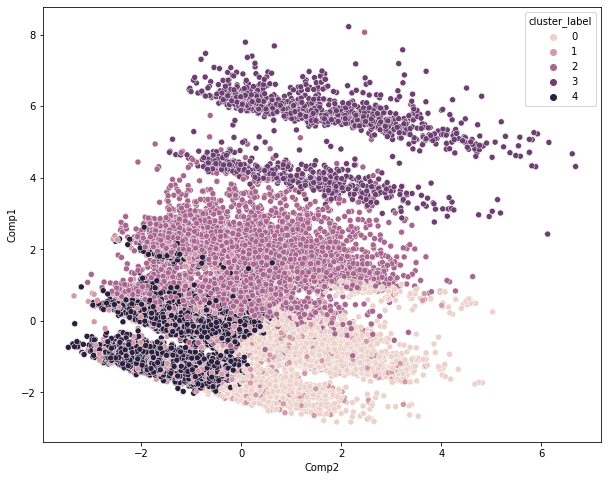

In [20]:
#visualize

plt.figure(figsize = (10, 8))
sns.scatterplot(data=df_seg_kmean, x="Comp2", y="Comp1", hue="cluster_label")
plt.show()

In [21]:
def fea_clus(raw_feature):
    df = pd.DataFrame(df_seg_kmean.groupby(['cluster_label']).agg('median').reset_index())
    fig, axs = plt.subplots(1, 1,figsize =(12, 5), tight_layout = True)
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x='cluster_label', y=raw_feature, data=df)
    ax.title.set_text('median {} by clsuter'.format(raw_feature))
    plt.show()

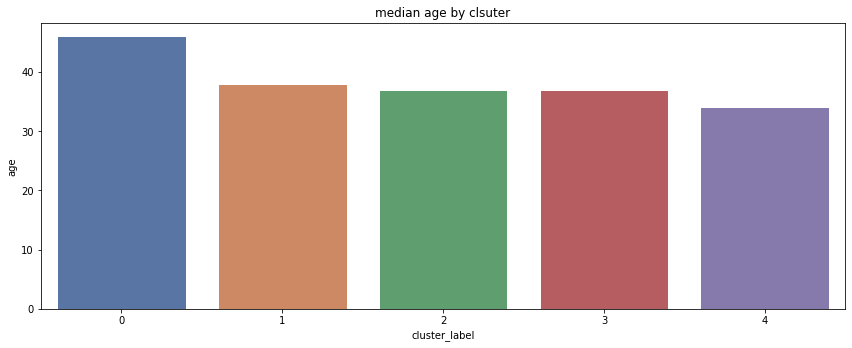

In [22]:
fea_clus('age')

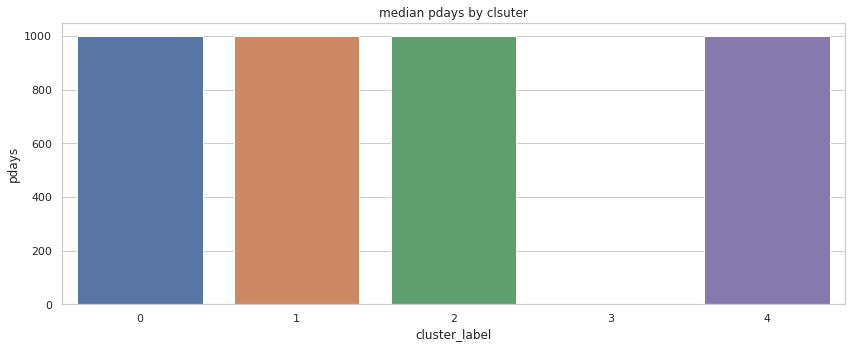

In [23]:
fea_clus('pdays')

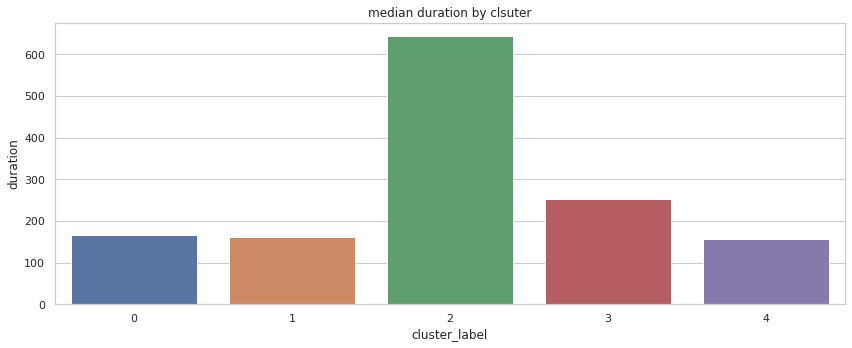

In [24]:
fea_clus('duration')

In [25]:
df = df_seg_kmean.groupby(['cluster_label'])
d1 = df['marital'].value_counts()

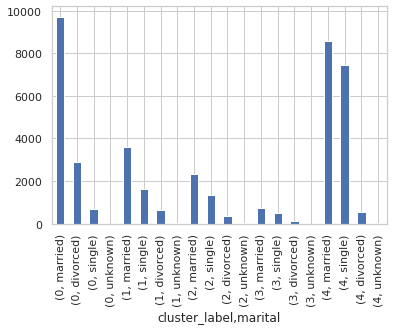

In [26]:
d1.plot.bar()

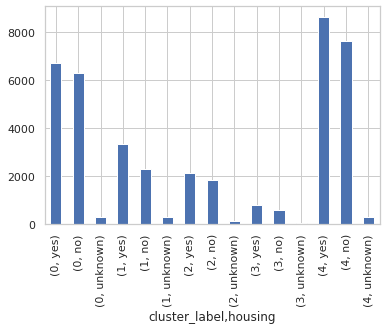

In [27]:
d2 = df['housing'].value_counts()
d2.plot.bar()

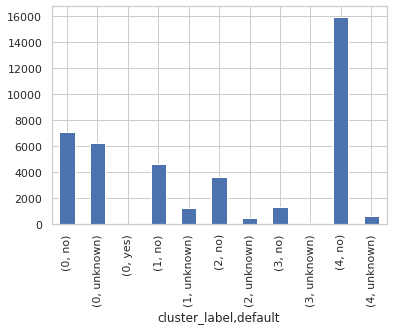

In [28]:
d5 = df['default'].value_counts()
d5.plot.bar()

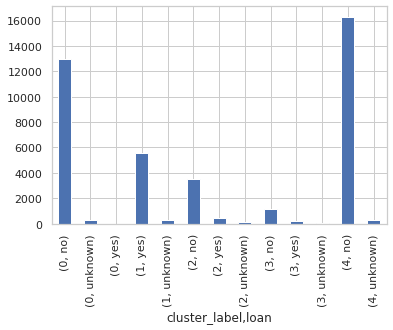

In [29]:
d6 = df['loan'].value_counts()
d6.plot.bar()

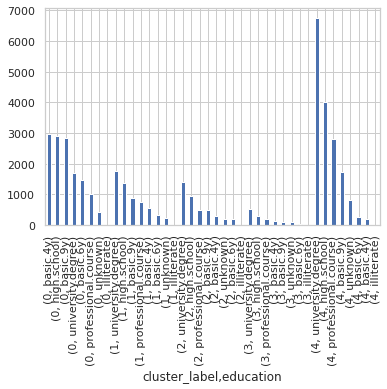

In [30]:
d3 = df['education'].value_counts()
d3.plot.bar()

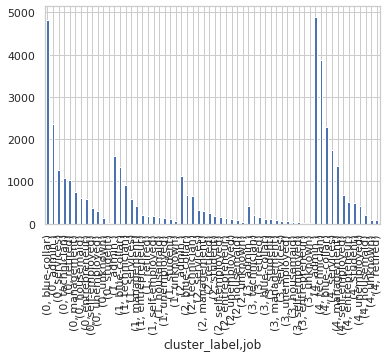

In [31]:
d4 = df['job'].value_counts()
d4.plot.bar()

### Use Kmeans to augment the training features for classifciation

https://towardsdatascience.com/kmeans-clustering-for-classification-74b992405d0a



In [32]:
from sklearn.metrics import cohen_kappa_score,  average_precision_score


# define functions for model performance evaluation
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print("Kappa- ", cohen_kappa_score(y_test, predictions))
    print("F1- ", f1_score(y_test, predictions))
    print("ROC_AUC_score- ", roc_auc_score(y_test, predictions))
    print("PR AUC- ", average_precision_score(y_test, predictions))


def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_curve(y_test, predictions):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
    fig.tight_layout()
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    ax1.set_title('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')

    lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test, predictions)
    ax2.set_title('Precision-Recall AUC Curve')
    ax2.plot(lr_recall, lr_precision, marker='.')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])

    plt.show()

In [33]:
df_clus_x = df_clus.drop('y', axis=1)
df_clus_x.head()

,age,job,marital,education,default,housing,loan,duration,pdays,poutcome
0,56,3,1,0,0,0,0,261,999,1
1,57,7,1,3,1,0,0,149,999,1
2,37,7,1,3,0,2,0,226,999,1
3,40,0,1,1,0,0,0,151,999,1
4,56,7,1,3,0,0,2,307,999,1


In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_2 = scaler.fit_transform(df_clus_x)

In [35]:
#there is no obvious infection point on the curve, so we will use 80% as threshold to determine the number of principal component

pca = PCA(n_components = 7)

x_pca2 = pca.fit_transform(x_2)

In [36]:
#using two cluster and concat the cluster as new feature with original dataset

kmeans_pca = KMeans(n_clusters=2, init = 'k-means++', random_state=42)
kmeans_pca.fit(x_pca2)

data_2['cluster_label'] = kmeans_pca.labels_
data_2.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,cluster_label
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1


In [37]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import imblearn

def data_pre(df):

    df_tran = df.drop(['duration'], axis=1)
    
    #separate the label column
    y = df_tran['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
    print(y.value_counts())
    
    #one-hotencoding
    x = df_tran.drop('y', axis=1)
    x_oh = pd.get_dummies(x)
    x_oh = x_oh.drop(['job_unknown','marital_unknown','education_unknown', 'default_unknown', 'housing_unknown', 'loan_unknown'], axis=1)
    print(x_oh.shape)

    #normalization & train_test_split
    scaler = StandardScaler()
    x_sca = scaler.fit_transform(x_oh)

    x_train,x_test,y_train,y_test = train_test_split(x_sca, y, test_size = 0.2, stratify=y, random_state=42)
    
    #SMOTE - data imbalancing resolving
    smote = SMOTE()
    x_s, y_s = smote.fit_resample(x_train, y_train)
    print('Original dataset shape', len(x_train))
    print('Resampled dataset shape', len(x_s))

    return x_s, y_s, x_test, y_test


In [38]:
x_s, y_s, x_test, y_test = data_pre(data_2)

0    36548
1     4640
Name: y, dtype: int64
(41188, 57)
Original dataset shape 32950
Resampled dataset shape 58476


In [39]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(solver='lbfgs', random_state = 100)
lg.fit(x_s, y_s)

LogisticRegression(random_state=100)

In [40]:
preds_lg = lg.predict(x_test)
preds_lg =  [1 if i>0.5 else 0 for i in preds_lg ]

In [41]:
print_validation_report(y_test, preds_lg)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      7310
           1       0.35      0.66      0.46       928

    accuracy                           0.83      8238
   macro avg       0.65      0.75      0.68      8238
weighted avg       0.88      0.83      0.85      8238

Accuracy Score: 0.8258072347657198
Kappa-  0.3679972114214105
F1-  0.46072904922961294
ROC_AUC_score-  0.7536727852728903
PR AUC-  0.27189207642057045


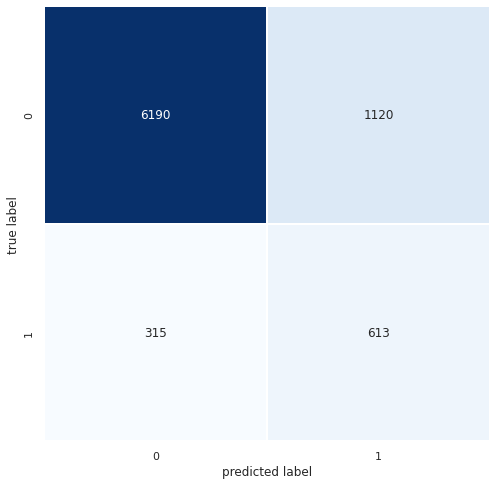

In [42]:
plot_confusion_matrix(y_test, preds_lg)

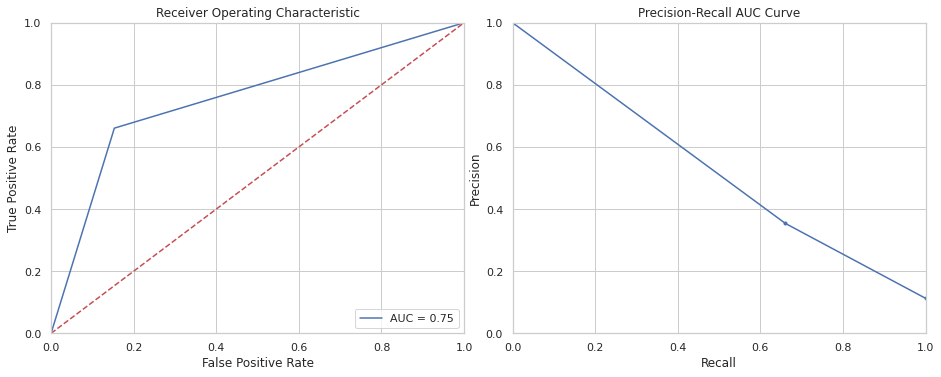

In [43]:
plot_curve(y_test, preds_lg)

### Gower Distance 
https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad

In [5]:
df_gow = data_2[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'duration', 'pdays', 'poutcome', 'y']]

In [6]:
pip install gower

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import gower

distance_matrix = gower.gower_matrix(df_gow)

In [ ]:
from sklearn.cluster import DBSCAN

# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.3, 
                        min_samples=2, 
                        metric="precomputed")

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

# Adding the results to a new column in the dataframe
df_gow["cluster"] = dbscan_cluster.labels

In [ ]:
df_gow["cluster"].value_counts

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(distance_matrix)

In [ ]:
df_gow["x_component"]=X_embedded[:,0]
df_gow["y_component"]=X_embedded[:,1]

In [ ]:
import plotly.express as px
    
fig = px.scatter(df, x="x_component", y="y_component", hover_name="age", color = "labels", size_max=60)
fig.update_layout(
     height=800)
fig.show()

### Agglomerative Clustering


In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
agg_clu = AgglomerativeClustering(n_clusters=5)
agg_clu.fit(x_pca)

AgglomerativeClustering(n_clusters=5)

In [ ]:
# Before all else, we’ll create a new data frame. It allows us to add in the values of the separate components to our segmentation data set. The components’ scores are stored in the ‘scores P C A’ variable. Let’s label them Component 1, 2 and 3. In addition, we also append the ‘K means P C A’ labels to the new data frame.

df_seg_agg = data_2[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'duration', 'pdays', 'poutcome', 'y']]


In [ ]:
df_seg_agg = pd.concat([df_seg_agg , pd.DataFrame(x_pca)], axis = 1)
df_seg_agg.columns.values[-7:] = ['Comp1', 'Comp2','Comp3','Comp4','Comp5','Comp6','Comp7']

df_seg_agg ['cluster_label'] = agg_clu.labels_
df_seg_agg.head(10)

,age,job,marital,education,default,housing,loan,duration,pdays,poutcome,y,Comp1,Comp2,Comp3,Comp4,Comp5,Comp6,Comp7,cluster_label
0,56,housemaid,married,basic.4y,no,no,no,261,999,nonexistent,no,-0.640537,1.547422,0.078671,-0.411936,-0.939176,0.581371,-0.323710,0
1,57,services,married,high.school,unknown,no,no,149,999,nonexistent,no,-0.941106,1.788026,-0.569360,0.316186,-1.200333,-0.299727,1.559731,4
2,37,services,married,high.school,no,yes,no,226,999,nonexistent,no,-0.136472,-0.253236,-0.301470,0.626802,0.206516,-0.952029,-0.190458,0
3,40,admin.,married,basic.6y,no,no,no,151,999,nonexistent,no,-0.624216,0.519635,-0.159462,-1.187937,-0.849821,0.787208,-0.809673,0
4,56,services,married,high.school,no,no,yes,307,999,nonexistent,no,-0.240205,0.873396,-0.101243,0.942933,0.800062,2.077514,1.353590,1
5,45,services,married,basic.9y,unknown,no,no,198,999,nonexistent,no,-0.852439,1.291999,-0.395517,-0.312721,-1.203177,-0.430462,1.700838,4
6,59,admin.,married,professional.course,no,no,no,139,999,nonexistent,no,-0.480920,0.928848,-0.388029,0.361557,-0.893795,1.131175,-1.089833,0
7,41,blue-collar,married,unknown,unknown,no,no,217,999,nonexistent,no,-0.520344,0.429587,-0.405953,-0.288266,-1.053327,0.270507,0.554440,0
8,24,technician,single,professional.course,no,yes,no,380,999,nonexistent,no,0.654984,-2.202682,-0.087829,0.377761,0.036437,-1.360463,0.639292,0
9,25,services,single,high.school,no,yes,no,50,999,nonexistent,no,0.011688,-1.885115,-0.768320,-0.347517,0.179040,-1.284770,0.207502,0


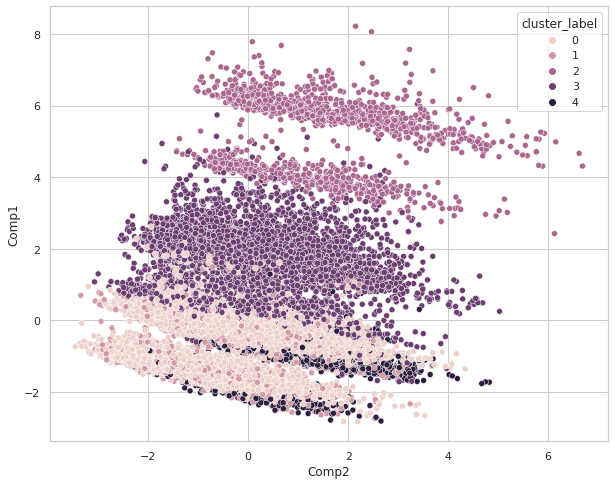

In [ ]:
#visualize

plt.figure(figsize = (10, 8))
sns.scatterplot(data=df_seg_agg, x="Comp2", y="Comp1", hue="cluster_label")
plt.show()

In [ ]:
def fea_clus(raw_feature):
    df = pd.DataFrame(df_seg_agg.groupby(['cluster_label']).agg('median').reset_index())
    fig, axs = plt.subplots(1, 1,figsize =(12, 5), tight_layout = True)
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x='cluster_label', y=raw_feature, data=df)
    ax.title.set_text('median {} by clsuter'.format(raw_feature))
    plt.show()

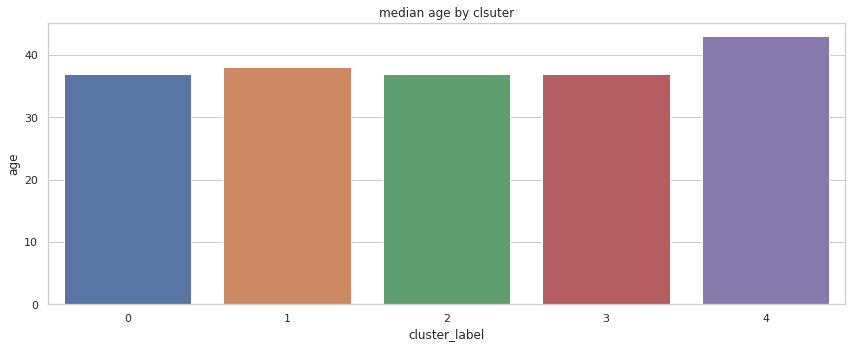

In [ ]:
fea_clus('age')

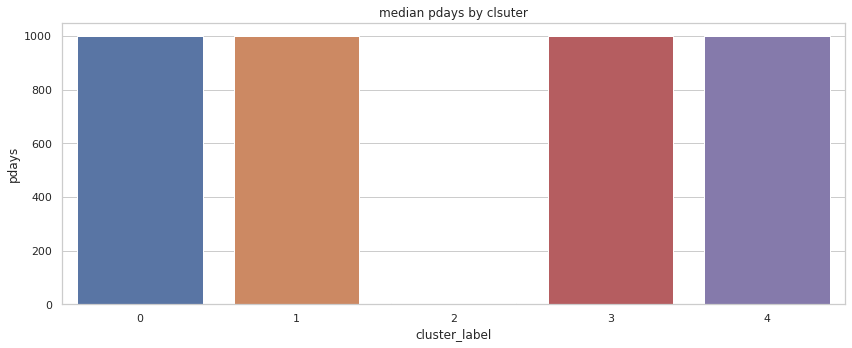

In [ ]:
fea_clus('pdays')

In [ ]:
df_agg = df_seg_agg.groupby(['cluster_label'])
da1 = df_agg['marital'].value_counts()

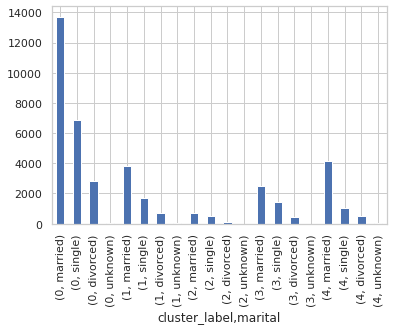

In [ ]:
da1.plot.bar()

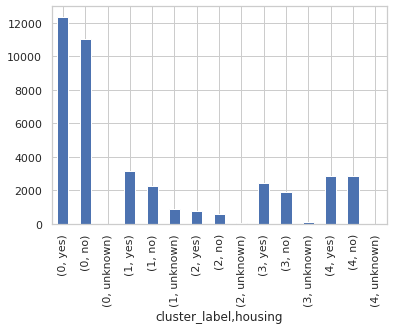

In [ ]:
da2 = df_agg['housing'].value_counts()
da2.plot.bar()

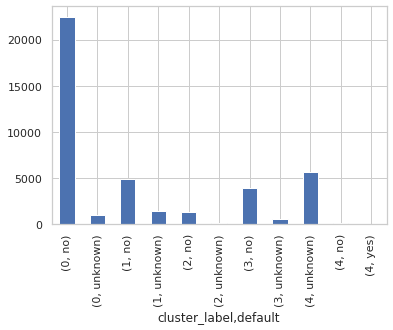

In [ ]:
da3 = df_agg['default'].value_counts()
da3.plot.bar()

In [ ]:
y_agg = agg_clu.fit_predict(x_pca)

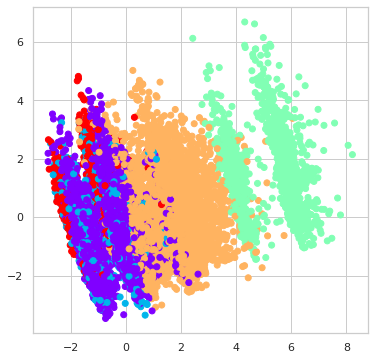

In [ ]:
plt.figure(figsize =(6, 6))
plt.scatter(df_seg_agg['Comp1'], df_seg_agg['Comp2'],
           c = y_agg, cmap ='rainbow')
plt.show()